http://www.shanetalk.com/2017/06/16/How-to-deploy-Flask-on-the-Aliyun/

In [190]:
import keras
import jieba
import re
from collections import Counter
import string
import seaborn as sns
import numpy as np
import pandas as pd
import jieba.analyse as anls
import jieba.posseg as pseg
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from sklearn.model_selection import train_test_split
import pydot
import pickle

Reference
- https://github.com/x-hacker/CNN_ChineseTextBinaryClassify
- https://www.sogou.com/labs/resource/cs.php
- https://www.libinx.com/2018/text-classification-cnn-by-tensorflow/

# Read in  some example data

In [122]:
%%time
f = open('./data/chinese_news/news_sohusite_xml.dat',"rb")
lines = [l.decode('gbk','ignore') for l in f]

CPU times: user 15.2 s, sys: 3.74 s, total: 18.9 s
Wall time: 19.8 s


In [123]:
print(lines[:5])

['<doc>\n', '<url>http://gongyi.sohu.com/20120706/n347457739.shtml</url>\n', '<docno>98590b972ad2f0ea-34913306c0bb3300</docno>\n', '<contenttitle>深圳地铁将设立ＶＩＰ头等车厢\u3000买双倍票可享坐票</contenttitle>\n', '<content>南都讯\u3000记者刘凡\u3000周昌和\u3000任笑一\u3000继推出日票后，深圳今后将设地铁ＶＩＰ头等车厢，设坐票制。昨日，《南都ＭＥＴＲＯ》创刊仪式暨２０１２年深港地铁圈高峰论坛上透露，在未来的１１号线上将增加特色服务，满足不同消费层次的乘客的不同需求，如特设行李架的车厢和买双倍票可有座位坐的ＶＩＰ车厢等。Ｂ厶成希深圳市政府副秘书长、轨道交通建设办公室主任赵鹏林透露，地铁未来的方向将分等级，满足不同层次的人的需求，提供不同层次的有针对的服务。其中包括一些档次稍微高一些的服务。“我们要让公共交通也能满足档次稍高一些的服务”。比如，尝试有座位的地铁票服务。尤其是一些远道而来的乘客，通过提供坐票服务，让乘坐地铁也能享受到非常舒适的体验。他说，这种坐票的服务有望在地铁３期上实行，将加挂２节车厢以实施花钱可买座位的服务。！拔颐窍Ｍ轨道交通和家里开的车一样，分很多种。”赵鹏林说，比如有些地铁是“观光线”，不仅沿途的风光非常好，还能凭一张票无数次上下，如同旅游时提供的“通票服务”。再比如，设立可以放大件行李的车厢，今后通过设专门可放大件行李的座位，避免像现在放行李不太方便的现象。“未来地铁初步不仅在干线上铺设，还会在支线、城际线上去建设。”！熬醯萌绻车费不太贵的话，还是愿意考虑的。”昨日市民黄小姐表示，尤其是从老街到机场这一段，老街站每次上下客都很多人，而如果赶上上下班高峰期，特别拥挤，要一路从老街站站到机场，４０、５０分钟还是挺吃力的，宁愿多花点钱也能稍微舒适一点。但是白领林先生则表示，自己每天上下班都要坐地铁，出双倍车资买坐票费用有点高。</content>\n']


In [124]:
%%time
categories = []
contents = []
for line in lines:
    if '<url>' in line:
        url = line.split('<url>')[1].split('</url>')[0]
        category = re.findall(r"http://(.*?).sohu.com/", url)
        categories.append(category[0])
    if '<content>' in line:
        content = line.split('<content>')[1].split('</content>')[0]
        contents.append(content)

CPU times: user 6.12 s, sys: 524 ms, total: 6.65 s
Wall time: 6.69 s


In [125]:
contents, categories = zip(*[(k,v) for k, v in zip(contents, categories) if k !=''])

In [126]:
df = pd.DataFrame({'contents':contents, 'categories':categories})
df.head()

,contents,categories
0,南都讯 记者刘凡 周昌和 任笑一 继推出日票后，深圳今后将设地铁ＶＩＰ头等车厢，设坐票制。昨...,gongyi
1,同心县地处宁夏中部干旱带的核心区， 冬寒长，春暖迟，夏热短，秋凉早，干旱少雨，蒸发强烈，风大...,gongyi
2,不满一岁的永康是个饱经病痛折磨的孩子，２０１１年７月５日出生的他，患有先天性心脏病、疝气，一...,gongyi
3,就废弃茶叶被转手事件发声明１颈ㄑ叮记者刘俊） “我们也是受害者！”昨日，有媒体报道称康师傅的...,gongyi
4,·奖励办法：率先提交的前１００个创意项目，经评估，可优先资助实施。！ぷ裳电话：０１０－６７７...,gongyi


In [127]:
df['categories'].value_counts()[:10]

roll           671000
product.it     149388
news            63836
db.auto         56272
sports          37211
stock           32178
pic.yule        27350
dealer.auto     25052
business        20096
saa.auto        19245
Name: categories, dtype: int64

In [130]:
df = df[df['categories'].isin(['db.auto','sports','stock'])]

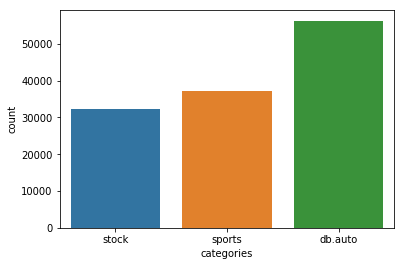

In [131]:
sns.countplot(df['categories'])

# Pre-processing

## 全角转半角

In [132]:
def strQ2B(ustring):
    rstring = ""
    for uchar in ustring:
        inside_code=ord(uchar)
        if inside_code == 12288:                              #全角空格直接转换            
            inside_code = 32 
        elif (inside_code >= 65281 and inside_code <= 65374): #全角字符（除空格）根据关系转化
            inside_code -= 65248

        rstring += chr(inside_code)
    return rstring

In [133]:
%%time
df['contents'] = [''.join([strQ2B(c) for c in x]) for x in df.contents]
df.head()

CPU times: user 36.5 s, sys: 1.1 s, total: 37.6 s
Wall time: 37.8 s


## Jieba Word Parsing

### Jieba Parsing

In [134]:
text = '继推出日票后，深圳今后将设地铁VIP头等车厢，设坐票制。'
text

'继推出日票后，深圳今后将设地铁VIP头等车厢，设坐票制。'

In [135]:
seg_list = jieba.lcut(text, cut_all=True)
print("【全模式】：" + "/ ".join(seg_list)) 

【全模式】：继/ 推出/ 日/ 票/ 后/ / / 深圳/ 今后/ 将/ 设/ 地铁/ VIP/ 头等/ 头等车厢/ 车厢/ / / 设/ 坐票/ 坐票制/ / 


In [136]:
seg_list = jieba.lcut(text, cut_all=False, HMM =False)
print("【未启用 HMM】：" + "/ ".join(seg_list)) 

【未启用 HMM】：继/ 推出/ 日/ 票/ 后/ ，/ 深圳/ 今后/ 将/ 设/ 地铁/ VIP/ 头等车厢/ ，/ 设/ 坐票制/ 。


In [137]:
seg_list = jieba.lcut(text, cut_all=False)
print("【精确模式】：" + "/ ".join(seg_list)) 

【精确模式】：继/ 推出/ 日票/ 后/ ，/ 深圳/ 今后/ 将/ 设/ 地铁/ VIP/ 头等车厢/ ，/ 设/ 坐票制/ 。


In [138]:
%%writefile ./script/customized_dict.txt
# For test: add customized dictionary:
头等车厢

Overwriting ./script/customized_dict.txt


In [139]:
# Loading dict
jieba.load_userdict("./script/customized_dict.txt")

In [140]:
seg_list = jieba.lcut(text, cut_all=False)
print("【载入字典】：" + "/ ".join(seg_list)) 

【载入字典】：继/ 推出/ 日票/ 后/ ，/ 深圳/ 今后/ 将/ 设/ 地铁/ VIP/ 头等车厢/ ，/ 设/ 坐票制/ 。


In [141]:
# Add Dict:
jieba.add_word('坐票制')

In [142]:
seg_list = jieba.lcut(text, cut_all=False)
print("【调整字典】：" + "/ ".join(seg_list)) 

【调整字典】：继/ 推出/ 日票/ 后/ ，/ 深圳/ 今后/ 将/ 设/ 地铁/ VIP/ 头等车厢/ ，/ 设/ 坐票制/ 。


### Jieba Keyword Extraction

In [148]:
for x, w in anls.extract_tags(df['contents'][0], topK=10, withWeight=True):
    print('%s %s' % (x, w))

温和 0.1790732744968421
辖区 0.16119742845552631
欧债 0.15729957240657894
不确定性 0.13855842571953947
制造业 0.1287541566935526
乐观 0.11996512347019736
企业 0.11109926802499999
美国 0.10938411135947368
招聘 0.10852879568039474
经济 0.09405736347684211


In [149]:
for x, w in anls.textrank(df['contents'][0], withWeight=True, topK=10):
    print('%s %s' % (x, w))

美国 1.0
支出 0.8546251140595224
制造业 0.8066501611519553
企业 0.803434606179747
经济 0.7244635859284279
不确定性 0.7063354297451476
政策 0.6936384129930083
环境 0.6459728854590001
危机 0.6018453730188696
辖区 0.5880932580054647


### PoS Tagging

In [150]:
words = pseg.cut(df['contents'][0][:20])
for word, flag in words:
    print("{0} {1}".format(word, flag))

美国联邦储备委员会 nt
( x
简称 v
Fed eng
) x
周三 t
发布 v


### Apply cut to all

Due to computation time, only first 500 characters.

In [151]:
%%time
contents = []
count = 0
L = len(df['contents'])
for content in df['contents']:
    contents.append([w for w in jieba.cut(content[:500], cut_all=False)])
    count += 1
    if count % 10000 == 0:
        print('Finished:', count, '/', L)

Finished: 10000 / 125661
Finished: 20000 / 125661
Finished: 30000 / 125661
Finished: 40000 / 125661
Finished: 50000 / 125661
Finished: 60000 / 125661
Finished: 70000 / 125661
Finished: 80000 / 125661
Finished: 90000 / 125661
Finished: 100000 / 125661
Finished: 110000 / 125661
Finished: 120000 / 125661
CPU times: user 2min 55s, sys: 3.09 s, total: 2min 58s
Wall time: 2min 58s


In [155]:
df['contents'] = contents
df.head()

,contents,categories
0,"[美国联邦储备委员会, (, 简称, Fed, ), 周三, 发布, 黄皮书, ,, 称, ...",stock
1,"[最高人民检察院, 日前, 下发, 《, 关于, 进一步, 依法, 严厉打击, 食品安全, ...",stock
2,"[海默, 科技, 今日, 发布, 说明, 公告, ,, 回应, 媒体报道, 称, “, 公司...",stock
3,"[科大, 智能, (, 300222, ), 6, 月, 25, 日, 晚间, 公告, ,,...",stock
4,"[银河证券, 5, 日, 发布, 2012, 年, 中期, 投资, 策略, 报告会, ,, ...",stock


## Remove stop characters

In [159]:
stop_words = [x for x in string.printable] + \
             ['《','》','“','”','、','。','…','·','-']

In [160]:
%%time
df['contents'] = [[w for w in content if w not in stop_words] for content in df['contents']]

CPU times: user 38.8 s, sys: 31.1 s, total: 1min 9s
Wall time: 1min 13s


In [161]:
df.head()

,contents,categories
0,"[美国联邦储备委员会, 简称, Fed, 周三, 发布, 黄皮书, 称, 月初, 至, 月末...",stock
1,"[最高人民检察院, 日前, 下发, 关于, 进一步, 依法, 严厉打击, 食品安全, 犯罪行...",stock
2,"[海默, 科技, 今日, 发布, 说明, 公告, 回应, 媒体报道, 称, 公司, 拟以, ...",stock
3,"[科大, 智能, 300222, 月, 25, 日, 晚间, 公告, 近日, 公司, 参与,...",stock
4,"[银河证券, 日, 发布, 2012, 年, 中期, 投资, 策略, 报告会, 会上, 发布...",stock


## Save processed data

In [166]:
pickle.dump( df, open( "./data/chinese_news/processed_df.p", "wb" ) )
df = pickle.load( open( "./data/chinese_news/processed_df.p", "rb" ) )

## Some summary

Frequent words

In [162]:
all_words = [word for content in df['contents'] for word in content]
freqs = Counter(all_words)

In [165]:
freqs.most_common(10)

[('的', 575162),
 ('恚', 271429),
 ('ǎ', 208140),
 ('↓', 189272),
 ('在', 158089),
 ('了', 128343),
 ('骸', 95255),
 ('和', 91934),
 ('是', 83492),
 ('个', 76455)]

sentence length

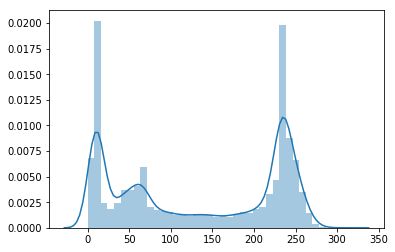

In [167]:
sns.distplot([len(content) for content in df['contents']])

# Prepare modelling data

In [169]:
X = df['contents']
Y = df['categories']

## Encoding for Y

In [173]:
Y, uniques = pd.factorize(df['categories'])

In [174]:
uniques

Index(['stock', 'sports', 'db.auto'], dtype='object')

In [175]:
NUM_CLASS = len(set(Y))
Y = keras.utils.to_categorical(Y, num_classes=3)
Y.shape

(125661, 3)

## Trim and add paddings for X

In [176]:
MAX_LEN = 150
VOCAB_SIZE = 1000

In [177]:
def pad_trim_review(review, MAX_LEN = 150):
    l = len(review)
    if  l >= MAX_LEN:
        return(review[:MAX_LEN])
    else:
        return(review + ['<PAD/>'] * (MAX_LEN - l))

In [178]:
dictionary = corpora.Dictionary(contents)
dictionary.filter_extremes(no_below = 1, no_above = 0.5, keep_n = VOCAB_SIZE)

In [180]:
contents_padded = [pad_trim_review(x, MAX_LEN) \
                   for x in X]

In [181]:
contents_padded_index = np.array([dictionary.doc2idx(x, unknown_word_index = VOCAB_SIZE) \
                                  for x in contents_padded])

In [182]:
contents_padded_index.shape

(125661, 150)

In [183]:
contents_padded_index[0]

array([1000, 1000, 1000, 1000,   20, 1000,   49, 1000,   55, 1000,   54,
         52, 1000,   25,    9,   60,   13,   27,   44, 1000, 1000, 1000,
         19,   54,   36, 1000, 1000, 1000, 1000,   48, 1000, 1000, 1000,
         52,   24, 1000,   32, 1000, 1000, 1000,   16,   13, 1000,   46,
         50, 1000,   35, 1000, 1000,   22, 1000,   57, 1000, 1000,   48,
       1000, 1000, 1000,   52, 1000,   15, 1000,   28, 1000, 1000, 1000,
       1000, 1000,   22,   39, 1000,   23,   14, 1000, 1000, 1000,   13,
         11, 1000,   44,   52, 1000,   19,   54,   36, 1000, 1000,   21,
         31,   43,   53, 1000, 1000, 1000, 1000,   64,   61,   17,   10,
       1000,   32, 1000, 1000, 1000, 1000, 1000, 1000, 1000,   63, 1000,
       1000, 1000,   22, 1000, 1000,   51, 1000, 1000,   18,   22, 1000,
         45, 1000,   47, 1000,    8, 1000, 1000,   18,   38, 1000,   48,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,   37, 1000, 1000,
         49,   13, 1000, 1000,   32,   29, 1000])

## Save processed data

In [209]:
pickle.dump({'X':contents_padded_index, 'Y':Y}, open( "./data/chinese_news/processed_data.p", "wb" ) )
data_dict = pickle.load( open( "./data/chinese_news/processed_data.p", "rb" ) )
X = data_dict['X']
Y = data_dict['Y']

## Split Train and Eval

In [210]:
X_train, X_eval, Y_train, Y_eval = train_test_split(X, Y, test_size=0.33, random_state=42)

# Define LSTM network

In [193]:
from keras.models import Sequential, Model
from keras import optimizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input,  SpatialDropout1D, Convolution1D, MaxPooling1D, LSTM

In [194]:
embedding_dim = 25
lstm_units = 120

In [214]:
model = Sequential()
model.add(Embedding(input_dim = VOCAB_SIZE + 1, 
                    output_dim = embedding_dim, 
                    input_length = MAX_LEN))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(units = lstm_units, 
               dropout = 0.2,  
               recurrent_dropout = 0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(rate = 0.5))
#model.add(Dense(1, activation='relu')) # continous
#model.add(Dense(1, activation='sigmoid')) # binary
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 25)           25025     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 150, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               70080     
_________________________________________________________________
dense_3 (Dense)              (None, 60)                7260      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 183       
Total params: 102,548
Trainable params: 102,548
Non-trainable params: 0
_________________________________________________________________


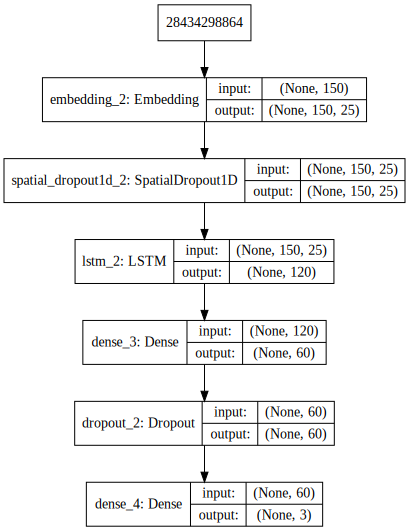

In [215]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

# Model training

In [216]:
batch_size = 128
num_epoches = 10

In [ ]:
model.compile(#loss='binary_crossentropy',
            loss = 'categorical_crossentropy',
            optimizer = optimizers.Adam(lr = 0.001))
model.fit(X_train, Y_train, 
          batch_size = batch_size, 
          validation_data=(X_eval, Y_eval), 
          epochs = num_epoches)

Instructions for updating:
Use tf.cast instead.
Train on 84192 samples, validate on 41469 samples
Epoch 1/10
84192/84192 [==============================] - 148s 2ms/step - loss: 0.6323 - val_loss: 0.4819
Epoch 2/10
84192/84192 [==============================] - 150s 2ms/step - loss: 0.5127 - val_loss: 0.4375
Epoch 3/10
84192/84192 [==============================] - 148s 2ms/step - loss: 0.2616 - val_loss: 0.0847
Epoch 4/10
84192/84192 [==============================] - 146s 2ms/step - loss: 0.1507 - val_loss: 0.0721
Epoch 5/10
84192/84192 [==============================] - 152s 2ms/step - loss: 0.1163 - val_loss: 0.0621
Epoch 6/10
84192/84192 [==============================] - 150s 2ms/step - loss: 0.0790 - val_loss: 0.0455
Epoch 7/10
84192/84192 [==============================] - 154s 2ms/step - loss: 0.0615 - val_loss: 0.0389
Epoch 8/10
44288/84192 [==============>...............] - ETA: 1:03 - loss: 0.0498

In [ ]:
from keras.models import load_model
model.save('./model/chinese_news_lstm.h5')  # creates a HDF5 file 'my_model.h5'
model = load_model('./model/chinese_news_lstm.h5')